In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:

import numpy as np
import pickle


class State:
    def __init__(self, BOARD_ROWS, BOARD_COLS, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.BOARD_ROWS = BOARD_ROWS
        self.BOARD_COLS = BOARD_COLS
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1

    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(self.BOARD_COLS * self.BOARD_ROWS))
        return self.boardHash

    def winner(self):
        # row
        for i in range(self.BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(self.BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(self.BOARD_COLS)])
        diag_sum2 = sum([self.board[i, self.BOARD_COLS - i - 1] for i in range(self.BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(self.BOARD_ROWS):
            for j in range(self.BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    # board reset
    def reset(self):
        self.board = np.zeros((self.BOARD_ROWS, self.BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self, rounds=100):
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break


    # play with human
    def play2(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)

                self.updateState(p2_action)
                self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break
                    
    def evaluate(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            board_hash = self.getHash()
            self.p1.addState(board_hash)
            # check board status if it is end

            win = self.winner()
            if win is not None:
                # self.showBoard()
                # ended with p1 either win or draw
                self.giveReward()
                self.p1.reset()
                self.p2.reset()
                self.reset()
                return win

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                self.updateState(p2_action)
                board_hash = self.getHash()
                self.p2.addState(board_hash)

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p2 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    return win



    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, self.BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, self.BOARD_COLS):
                token = ""
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')


class Player:
    def __init__(self, BOARD_ROWS, BOARD_COLS, name, exp_rate=0.3):
        self.name = name
        self.BOARD_ROWS = BOARD_ROWS
        self.BOARD_COLS = BOARD_COLS
        self.states = []  # record all positions taken
        self.lr = 0.3
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

    def getHash(self, board):
        boardHash = str(board.reshape(self.BOARD_COLS * self.BOARD_ROWS))
        return boardHash

    def chooseAction(self, positions, current_board, symbol):
        randValue = np.random.uniform(0, 1)
        value_max = value = -999
        if  randValue> self.exp_rate:

            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = -999 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p

        if  value_max == -999 :
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]

        # print("{} takes action {}".format(self.name, action))
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()


class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass

In [3]:
# training
board_size = 4
p1 = Player(board_size, board_size, "p1")
p2 = Player(board_size, board_size, "p2")

st = State(board_size, board_size, p1, p2)
print("training...")
st.play(10000)

p1.savePolicy()
p2.savePolicy()

training...
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000
Rounds 50000
Rounds 51000
Rounds 52000
Rounds 53000
Rounds 54000
Rounds 55000
Rounds 56000
Rounds 57000
Rounds 58000
Rounds 59000
Rounds 60000
Rounds 61000
Rounds 62000
Rounds 63000
Rounds 64000
Rounds 65000
Rounds 66000
Rounds 67000
Rounds 68000
Rounds 69000
Rounds 70000
Rounds 71000
Rounds 72000
Rounds 73000
Rounds 74000
Rounds 75000
Rounds 76000


In [10]:

check_p1 = Player("computer_1", board_size, board_size, exp_rate=0)
check_p1.loadPolicy("policy_p1")
check_p2 = Player("computer_2", board_size, board_size, exp_rate=0)
check_p2.loadPolicy("policy_p2")
st = State(board_size, board_size, p1, p2)

In [11]:
import matplotlib.pyplot as plt


win_percentage = 0
draw_percentage = 0 
lose_percentage = 0
for i in range(100):
    result = st.evaluate()
    if result == 1:
        win_percentage += 1
    elif result == -1:
        lose_percentage += 1
    else:
        draw_percentage += 1

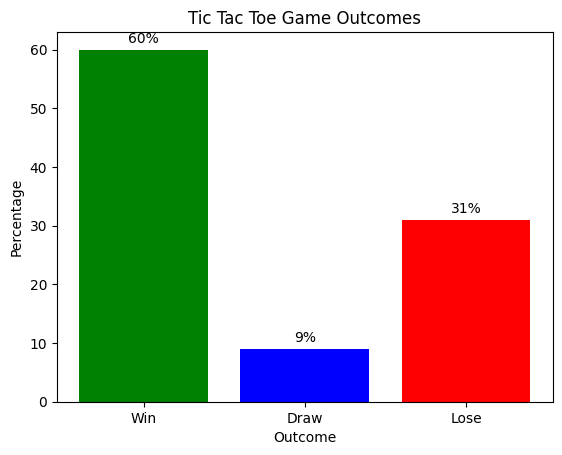

In [12]:


labels = ['Win', 'Draw', 'Lose']

percentages = [win_percentage, draw_percentage, lose_percentage]

fig, ax = plt.subplots()
bars = ax.bar(labels, percentages, color=['green', 'blue', 'red'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  
                textcoords="offset points", 
                ha='center', va='bottom')

plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title('Tic Tac Toe Game Outcomes')

plt.show()